In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import gym

import matplotlib.pyplot as plt

torch.manual_seed(42)

We can consider using a *baseline* $b$ in our result, which was originally introduced by [Williams, 1992](https://link.springer.com/article/10.1007/BF00992696). The paper in which the REINFORCE algorithm is introduced. 
$$
\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})=\frac{1}{m} \sum_{i=1}^{m} \sum_{t=1}^{H} \nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}\left(\mathbf{a}_{t}^{(i)} \mid \mathbf{s}_{t}^{(i)}\right)\left[\sum_{k=t}^{H} \gamma^{k} r\left(\mathbf{s}_{k}^{(i)}, \mathbf{a}_{k}^{(i)}\right)-b\right]
$$

In [217]:
env = gym.make("CartPole-v1")

env.observation_space, env.action_space, env._max_episode_steps

(Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32),
 Discrete(2),
 500)

In [218]:
import torch.nn as nn
import torch.optim as optim
from gym.spaces import Discrete, Box
from torch.distributions.categorical import Categorical


class Model(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(obs_dim, 128)
        self.linear2 = nn.Linear(128, act_dim)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return x

    
class Agent:
    def __init__(self, env, baseline= None, 
                 gamma=0.99, lr=3e-2, hidden_size=64):
        assert baseline is not None, \
            "Give a baseline to compute the policy gradient"
        
        assert isinstance(env.observation_space, Box), \
            "This example only works for envs with continuous state spaces."
        assert isinstance(env.action_space, Discrete), \
            "This example only works for envs with discrete action spaces."
        
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.n
        self.max_ep_len = env._max_episode_steps
        
        self.gamma = gamma
        self.baseline = baseline
        
        self.log_pi = Model(self.obs_dim, self.act_dim)
        self.opt = optim.Adam(self.log_pi.parameters(), lr=lr)
        
        self.v = Model(self.obs_dim, 1)
        self.opt_v = optim.Adam(self.v.parameters(), lr=lr)
    
    def update_policy(self, act, obs, baseline):
        self.opt.zero_grad()
        
        # Calculate the loss
        logp = self.get_policy(obs).log_prob(act)
        batch_loss = -(logp * baseline).mean()  
        
        batch_loss.backward()
        self.opt.step()
        return batch_loss
            
    def get_policy(self, obs):
        logits = self.log_pi(obs)
        return Categorical(logits=logits)
    
    def get_action(self, obs, deterministic = False):
        return self.get_policy(obs).sample().item()
    
    def sample_batch(self, batch_size=5000):
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths
        ep_rews = []            # list for rewards accrued throughout ep
        
        batch_episode = []      # for episodic samples of obs
        batch_full_rets = []    # for measuring full episode returns
        
        done = False
        o, ep_ret, ep_len, episode_obs = env.reset(), 0, 0, []
        while True:
            batch_obs.append(o)
            episode_obs.append(o)
            
            a = self.get_action(torch.as_tensor(o, dtype=torch.float32))
            o, r, done, _ = env.step(a)
            
            # save action, reward
            batch_acts.append(a)
            ep_rews.append(r)
            
            if done or(ep_len == self.max_ep_len):
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)
                
                # for MC value function estimation
                batch_full_rets.append(ep_rews)
                batch_episode.append(episode_obs)
                
                # Discounted reward
                batch_weights += list(self.baseline(ep_rews, 
                                                    batch_obs, 
                                                    batch_acts, 
                                                    self.gamma,
                                                    self.v))
                
                # reset episode-specific variables
                o, done, ep_rews, episode_obs = env.reset(), False, [], []
                
                if len(batch_obs) > batch_size:
                    break
                
        # value function estimation
        value_network_loss = self.update_value_network(
            batch_episode,
            batch_full_rets,
            batch_weights)
        
        batch_loss = self.update_policy(
            torch.as_tensor(batch_acts, dtype=torch.float32),
            torch.as_tensor(batch_obs, dtype=torch.float32),
            torch.as_tensor(batch_weights, dtype=torch.float32))

        return batch_loss, batch_rets, batch_lens
    
    def train(self, epochs=50, batch_size=5000, print_out=False):
        ep_loss, ep_rets, ep_len = [], [], []
        
        for i in range(epochs):
            batch_loss, batch_rets, batch_lens = self.sample_batch(
                batch_size=batch_size)
        
            ep_loss.append(batch_loss)
            ep_rets.append(np.mean(batch_rets))
            ep_len.append(np.mean(batch_lens))
            
            if print_out:
                print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f' %
                      (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))
        
        return ep_loss, ep_rets, ep_len
    
    # Monte Carlo approach
    def update_value_network(self, obs, rews, baseline):
        MSE = torch.nn.MSELoss()
        
        losses = []
        targets = []
        l = torch.Tensor([])
        for i in range(len(obs)):
            state = np.array(obs[i])
            reward = rews[i]
            if type(reward[0]) == torch.Tensor:
                reward = torch.cat(tuple(reward))
            else: 
                reward = torch.Tensor(reward)
                
            target = reward.unsqueeze(1)
            targets.append(target.mean().data.numpy())
            loss = MSE(target, self.v(torch.Tensor(state)))
            losses.append(loss)
        
        losses = torch.stack(losses).mean()
        self.opt_v.zero_grad()
        losses.backward()
        self.opt_v.step()
        return losses

Finally there are several possibilities for picking a baseline, namely,
$\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})=\mathbb{E}_{\mathbf{s}_{t}, \mathbf{a}_{t} \pi_{\boldsymbol{\theta}}(.)}\left[\nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}\left(\mathbf{a}_{t}^{(i)} \mid \mathbf{s}_{t}^{(i)}\right)\right] \psi_{t} \text { where } \psi_{t} \text { can be: }$

* $\sum_{t=0}^{H} \gamma^{t} r_{t}:$ total (discounted) reward of trajectory
* $\sum_{k=t}^{H} \gamma^{k-t} r_{k}:$ sum of rewards after $\mathbf{a}_{t}$
* $\sum_{k=t}^{H} \gamma^{k-t} r_{k}-b\left(\mathbf{s}_{t}\right):$ sum of rewards after $\mathbf{a}_{t}$ with baseline
* $\delta_{t}=r_{t}+\gamma V^{\pi}\left(\mathbf{s}_{t+1}\right)-V^{\pi}\left(\mathbf{s}_{t}\right):$ error, with $V^{\pi}\left(\mathbf{s}_{t}\right)=\mathbb{E}_{\mathbf{a}_{t}}\left[\sum_{k=0}^{H} \gamma^{k} r_{t+l}\right]$
* $\hat{Q}_{\phi}^{\pi_{\theta}}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)=\mathbb{E}_{a_{t+1}}\left[\sum_{k=0}^{H} \gamma^{k} r_{t+l}\right]:$ action-value function
* $\hat{A}_{\phi}^{\pi_{\theta}}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)=\hat{Q}_{\phi}^{\pi_{\theta}}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)-\hat{V}_{\phi}^{\pi_{\theta}}\left(\mathbf{s}_{t}\right)=\mathbb{E}\left[\delta_{t}\right]$, advantage function

In [153]:
# The baseline interface
# def baseline(rews, obs, acts, gamma = 0.99) -> list:
#   Return torch.Tensor

For $\psi_{t}$,
$\sum_{t=0}^{H} R(\tau) :$ total reward of trajectory

In [154]:
def sum_rewards(rews, obs = None, acts = None, gamma = None, v_net = None):
    """
    Apply a sum of rewards to all samples of the episode
    :return: nothing
    """
    summ = np.sum(rews)
    for i in range(len(rews)):
        rews[i] = summ
    return rews

sum_rewards([10, 1, 2, 1, 3, 10])

[27, 27, 27, 27, 27, 27]

For $\psi_{t}$, $\sum_{t=0}^{H} \gamma^{t} r_{t}:$ total (discounted) reward of trajectory

In [155]:
def discounted_sum_rewards(rews, obs = None, acts = None, gamma = None, v_net = None):
    summation = 0
    
    for i in reversed(range(len(rews))):
        summation = summation * gamma + rews[i]
        rews[i] = summation
    return rews    
    
discounted_sum_rewards([10, 1, 2, 1, 3, 10], gamma = 0.99)

[26.312187529, 16.4769571, 15.63329, 13.771, 12.9, 10.0]

For $\psi_{t}$, 
$\sum_{k=t}^{H} \gamma^{k-t} r_{k}-b\left(\mathbf{s}_{t}\right):$ sum of rewards after $\mathbf{a}_{t}$ with baseline where the baseline is the average

In [156]:
def discounted_sum_rewards_normalized(rews, obs = None, acts = None, gamma = None, v_net = None):
    summation = 0
    
    reward_std = np.std(reward_pool)
    if reward_std > 0:
        reward_mean = np.mean(reward_pool)
            
    for i in reversed(range(len(rews))):
        summation = summation * gamma + rews[i]
        rews[i] = (summation - reward_mean) / reward_std
    return rews    

# Take in mind this does not work on all environments, hence for the cartpole
# environment this doesn't change anything
discounted_sum_rewards([10, 1, 2, 1, 3, 10], gamma = 0.99)

[26.312187529, 16.4769571, 15.63329, 13.771, 12.9, 10.0]

For $\psi_{t}$,
As discussed in [OpenAI SpinningUp](https://spinningup.openai.com/en/latest/spinningup/extra_pg_proof1.html),

In [157]:
def reward_to_go(rews, obs = None, acts = None, gamma = None, v_net = None):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    
    for i in reversed(range(n)):
        rtgs[i] = gamma * rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return rtgs

reward_to_go([10, 1, 2, 1, 3, 10], gamma = 0.99)

array([21, 12, 12, 11, 11,  9])

For $\psi_{t}$, $\delta_{t}=r_{t}+\gamma V^{\pi}\left(\mathbf{s}_{t+1}\right)-V^{\pi}\left(\mathbf{s}_{t}\right):$ error, with $V^{\pi}\left(\mathbf{s}_{t}\right)=\mathbb{E}_{\mathbf{a}_{t}}\left[\sum_{k=0}^{H} \gamma^{k} r_{t+l}\right]$ as the rewards at every state will be 1 and the goal is to survive, this approach will not work on CartPole.

In [205]:
def discounted_sum_rewards_value_network(rews, obs, acts = None, gamma = None, v_net = None):
    summation = 0

    reward_std = np.std(rews)
    if reward_std > 0:
        reward_mean = np.mean(rews)

    for i in reversed(range(len(rews))):
        if i != 0:
            summation = summation * gamma + v_net(torch.Tensor(obs[i]))
        else:
            summation = v_net(torch.Tensor(obs[i])) * gamma
        rews[i] = summation - v_net(torch.Tensor(obs[i-1]))

    return rews

Evaluating the different baselines,

In [167]:
def run_agent(epochs=50, runs = 2, baseline = discounted_sum_rewards):
    agent = Agent(env, baseline=reward_to_go) # gamma = None, to train undiscounted
    loss, rets, length = [], [], []

    for i in range(runs):
        # gamma = None, to train undiscounted
        agent = Agent(env, baseline=baseline) 
        ep_loss, ep_rets, ep_len = agent.train(epochs=epochs)
        loss.append(ep_loss)
        rets.append(ep_rets)
        length.append(ep_len)
    return loss, rets, length

runs = 4
epochs = 200
loss_sum, rets_sum, length_sum = run_agent(epochs=epochs, runs=runs, baseline=sum_rewards)
loss_disc, rets_disc, length_disc = run_agent(epochs=epochs, runs=runs, baseline=discounted_sum_rewards)
loss_disc_rtg, rets_disc_rtg, length_disc_rtg = run_agent(epochs=epochs, 
                                                         runs=runs, 
                                                         baseline=reward_to_go)

/home/rob/.conda/envs/meta/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/home/rob/.conda/envs/meta/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/home/rob/.conda/envs/meta/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


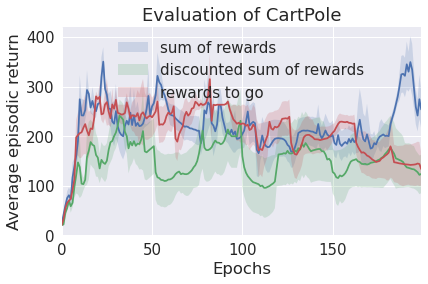

In [219]:
labels = ['sum of rewards', 'discounted sum of rewards', 'rewards to go']

palette = sns.color_palette()
sns.set(style="darkgrid", font_scale=1.5)

sns.tsplot(rets_disc, color=palette.pop(0))
sns.tsplot(rets_sum, color=palette.pop(0))
sns.tsplot(rets_disc_rtg, color=palette.pop(0))

plt.xlabel("Epochs")
plt.ylabel("Average episodic return")
plt.title("Evaluation of CartPole")
plt.legend(labels=labels)
plt.tight_layout(pad=0.5)
plt.show()